# Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

Пропишем требуемые пути и откроем данные

In [2]:
cwd = os.getcwd()

PATH_SALES_DF_TRAIN = cwd + '/data/raw/sales_df_train.csv'
PATH_PR_DF = cwd + '/data/raw/pr_df.csv'
PATH_ST_DF = cwd + '/data/raw/st_df.csv'

PATH_TO_SAVE_SALES_TRAIN_DF = cwd + '/data/preprocessing/preproc_sales_df_train.csv'
PATH_TO_SAVE_ST_DF = cwd + '/data/preprocessing/preproc_st_df.csv'
PATH_TO_SAVE_PR_DF = cwd + '/data/preprocessing/preproc_pr_df.csv'
PATH_TO_SAVE_TRAIN_DF = cwd + '/data/preprocessing/preproc_df_train.csv'

In [3]:
sales_df_train = pd.read_csv(PATH_SALES_DF_TRAIN)
pr_df = pd.read_csv(PATH_PR_DF)
st_df = pd.read_csv(PATH_ST_DF)

Поскольку предсказывать будем только общее количество продаж товара(pr_sales_in_units), то в датасете sales_df_train оставим только столбцы st_id, pr_sku_id (для джойна с другими датасетами), столбец с датой date и целевой признок pr_sales_in_units

In [4]:
sales_df_train = sales_df_train[['st_id', 'pr_sku_id', 'date', 'pr_sales_in_units']]

## Предообработка данных по товарам

Согласно EDA нам необходимо сделать метку для отнесения товара к той или иной категории, согласно динамике цен на них добавим такой столбец в датасет pr_df

In [5]:
pr_df.loc[pr_df['pr_cat_id']=='c559da2ba967eb820766939a658022c8', 'group_cat'] = 'cat_1'
pr_df.loc[pr_df['pr_subcat_id']=='60787c41b04097dfea76addfccd12243', 'group_cat'] = 'cat_2'
pr_df.loc[pr_df['pr_subcat_id']=='ca34f669ae367c87f0e75dcae0f61ee5', 'group_cat'] = 'cat_3'
pr_df.loc[pr_df['pr_cat_id'].isin(['e58cc5ca94270acaceed13bc82dfedf7', 
                                      'fb2fcd534b0ff3bbed73cc51df620323']), 'group_cat'] = 'cat_4'
pr_df.loc[pr_df['pr_cat_id'].isin(['3de2334a314a7a72721f1f74a6cb4cee', 
                                      'f3173935ed8ac4bf073c1bcd63171f8a',
                                      'b59c67bf196a4758191e42f76670ceba']), 'group_cat'] = 'cat_5'
pr_df.loc[pr_df['pr_cat_id'].isin(['28fc2782ea7ef51c1104ccf7b9bea13d', 
                                      '9701a1c165dd9420816bfec5edd6c2b1', 
                                      '5caf41d62364d5b41a893adc1a9dd5d4', 
                                      '186a157b2992e7daed3677ce8e9fe40f', 
                                      '2df45244f09369e16ea3f9117ca45157', 
                                      '6d9c547cf146054a5a720606a7694467', 
                                      '535ab76633d94208236a2e829ea6d888', 
                                      'a6ea8471c120fe8cc35a2954c9b9c595']), 'group_cat'] = 'cat_6'
pr_df.loc[pr_df['pr_cat_id']=='f9ab16852d455ce9203da64f4fc7f92d', 'group_cat'] = 'cat_7'
pr_df.loc[pr_df['pr_cat_id'].isin(['b7087c1f4f89e63af8d46f3b20271153', 
                                      'f93882cbd8fc7fb794c1011d63be6fb6']), 'group_cat'] = 'cat_8'
pr_df.loc[pr_df['pr_cat_id']=='faafda66202d234463057972460c04f5', 'group_cat'] = 'cat_9'
pr_df.loc[pr_df['pr_cat_id']=='fd5c905bcd8c3348ad1b35d7231ee2b1', 'group_cat'] = 'cat_10'
pr_df.loc[pr_df['pr_cat_id']=='c9f95a0a5af052bffce5c89917335f67', 'group_cat'] = 'cat_11'
pr_df['group_cat'] = pr_df['group_cat'].fillna('cat_12')
pr_df = pr_df.drop(['pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id'], axis=1)

Переименуем столбец

In [6]:
pr_df.head()

,pr_sku_id,group_cat
0,fd064933250b0bfe4f926b867b0a5ec8,cat_3
1,71c9661741caf40a92a32d1cc8206c04,cat_1
2,00b72c2f01a1512cbb1d3f33319bac93,cat_12
3,9bc40cd2fe4f188f402bb41548c5e15c,cat_3
4,3a74a370c8eb032acb11ad9119242b8f,cat_1


Сохраним получившийся датасет

In [7]:
pr_df.to_csv(PATH_TO_SAVE_PR_DF)

Присоединим получившийся датасет к исходным данным

In [8]:
sales_df_train = sales_df_train.merge(pr_df, on ='pr_sku_id')
sales_df_train = sales_df_train.drop('pr_sku_id', axis=1)

## Предообработка данных по продажам

Сгруппируем датасеты по уникальным сочитаниям даты, id магазина и категории товара, чтобы в дальнейшем можно было получать из них признаки

In [9]:
df_ts = (sales_df_train.groupby(['date', 'st_id', 'group_cat'])['pr_sales_in_units']
                       .agg('sum')
                       .reset_index(drop=False)
                       .sort_values(['date', 'st_id', 'group_cat']))
df_ts.index = df_ts['date']

Получим день недели и добавим флаг выходного дня, после чего удалим первоначальный столбец.

In [10]:
df_ts['date'] = pd.to_datetime(df_ts['date'])
df_ts['weekday'] = df_ts['date'].dt.weekday 
df_ts['weekend'] = (df_ts['weekday'] == 5) | (df_ts['weekday'] == 6)

In [11]:
df_ts = df_ts.drop('date', axis=1)

Добавим столбец сочетаний магазин_категории

In [12]:
df_ts['st_group_cat'] = df_ts['st_id'] + '_' + df_ts['group_cat']

Нам необходимо почистить данные от выбросов в качеств определяющего значения будем брать отношение текущего значени продаж к скользящему среднему за 30 дней. Чтобы определить порог выброса построим график

In [13]:
list_group_column = df_ts['st_group_cat'].unique()
df_date = df_ts.copy(deep=True)
for gr_col in list_group_column:
    new_name_mean = 'rolling_mean_30'
    df_date.loc[df_date['st_group_cat']==gr_col, 
                new_name_mean] = (df_date[df_date['st_group_cat']==gr_col]['pr_sales_in_units']
                                           .shift()
                                           .rolling(30)
                                           .mean())
df_date = df_date[['pr_sales_in_units', 'rolling_mean_30']]
df_date['ratio'] =  df_date['pr_sales_in_units'] / df_date['rolling_mean_30']
df_date.index = pd.to_datetime(df_date.index)
df_date = df_date.groupby('date')['ratio'].agg('mean').resample("1D").sum()

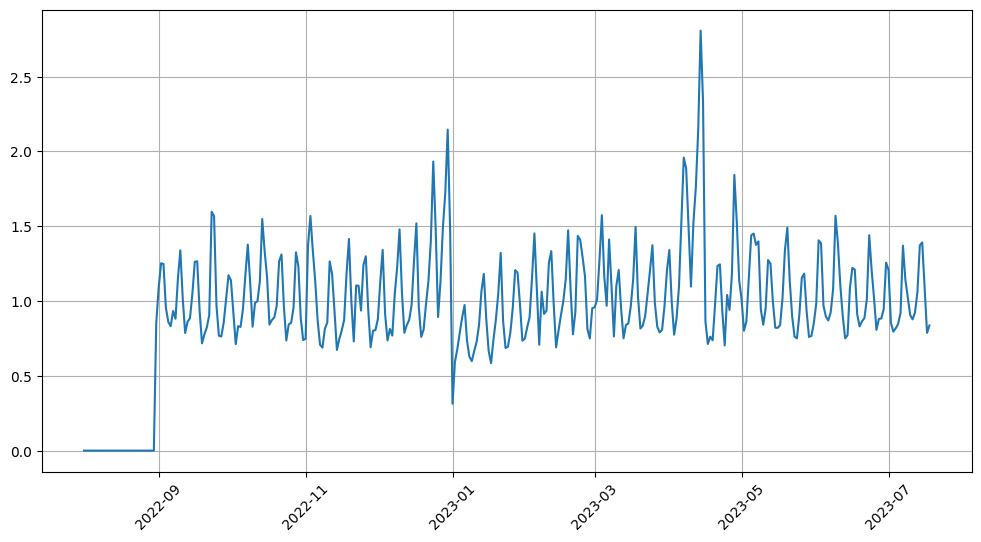

In [14]:
plt.figure(figsize=(12,6))
plt.plot(df_date)
plt.grid()
plt.xticks(rotation=45)
plt.show()

В качестве порога возьмём значение 1,7 это позволит уменьшить влияние выбросов, но приэтом оставит пики в праздничные дни

In [15]:
del df_date

Создадим функцию для обработки выбросов

In [16]:
def processing_outliers(df, group_column, column, threshold):
    list_group_column = df[group_column].unique()
    for gr_col in list_group_column:
        new_name_mean = 'rolling_mean_30'
        df.loc[df[group_column]==gr_col, new_name_mean] = (df[df[group_column]==gr_col][column]
                                                           .shift()
                                                           .rolling(30)
                                                           .mean())
    df['ratio'] = df[column] / df['rolling_mean_30']
    df.loc[df['ratio'] > threshold, column] = df[df['ratio'] > threshold]['rolling_mean_30'] * threshold
    df = df.drop(['ratio', 'rolling_mean_30'], axis=1)
    return df

In [17]:
df_ts = processing_outliers(df_ts, 'st_group_cat', 'pr_sales_in_units', 1.7)

Создадим функцию которая будет возвращать средню цену в определённый день за какое-то количество предшествующих недель

In [18]:
def get_mean_in_day(df, group_column, weekday_column, column, n_week):
    list_group_column = df[group_column].unique()
    list_weekday_column = df[weekday_column].unique()
    for day in list_weekday_column:
        for gr_col in list_group_column:
            new_name_mean = f'mean_in_weekday_{n_week}_week'  
            df.loc[(df[group_column]==gr_col) &
                   (df[weekday_column]==day), new_name_mean] = (df[(df[group_column]==gr_col) &
                                                                   (df[weekday_column]==day)][column]
                                                               .shift()
                                                               .rolling(n_week)
                                                               .mean())
    return df

Будем получать данные за 4 недели

In [19]:
df_ts = get_mean_in_day(df_ts, 'st_group_cat', 'weekday', 'pr_sales_in_units', 4)

Создадим функцию для получения скользящих статистик по каждой из группировок

In [20]:
def get_rolling(df, group_column, column, n_day):
    list_group_column = df[group_column].unique()
    for gr_col in list_group_column:
        new_name_mean = f'rolling_mean_{n_day}'
        new_name_max = f'rolling_max_{n_day}'
        new_name_min = f'rolling_min_{n_day}'        
        new_name_max_min = f'rolling_max_min_{n_day}'
        new_name_ratio = f'rolling_ratio_{n_day}'     
        df.loc[df[group_column]==gr_col, new_name_mean] = (df[df[group_column]==gr_col][column]
                                                           .shift()
                                                           .rolling(n_day)
                                                           .mean())
        df.loc[df[group_column]==gr_col, new_name_max] = (df[df[group_column]==gr_col][column]
                                                           .shift()
                                                           .rolling(n_day)
                                                           .max())
        df.loc[df[group_column]==gr_col, new_name_min] = (df[df[group_column]==gr_col][column]
                                                           .shift()
                                                           .rolling(n_day)
                                                           .min())
        df[new_name_max_min] = (df[new_name_max] + df[new_name_min]) / 2
        df[new_name_ratio] = df[new_name_max_min] / df[new_name_mean]
    return df

In [21]:
df_ts = get_rolling(df_ts, 'st_group_cat', 'pr_sales_in_units', 7)
df_ts = get_rolling(df_ts, 'st_group_cat', 'pr_sales_in_units', 14)
df_ts = get_rolling(df_ts, 'st_group_cat', 'pr_sales_in_units', 30)

Создадим функцию для получения лагов в каждой из группировок

In [22]:
def get_lag(df, group_column, column, n_day):
    list_group_column = df[group_column].unique()
    for gr_col in list_group_column:
        new_name = f'lag_{n_day}'
        df.loc[df[group_column]==gr_col, new_name] = (df[df[group_column]==gr_col][column]
                                                                    .shift(n_day))
    return df

Добавим в датасет лаги в 1, 5, 6, 7 дней, затем также посчитаем среднее по лагам в 5, 6, 7 дней

In [23]:
df_ts = get_lag(df_ts, 'st_group_cat', 'pr_sales_in_units', 1)
df_ts = get_lag(df_ts, 'st_group_cat', 'pr_sales_in_units', 5)
df_ts = get_lag(df_ts, 'st_group_cat', 'pr_sales_in_units', 6)
df_ts = get_lag(df_ts, 'st_group_cat', 'pr_sales_in_units', 7)
df_ts['mean_week_lag'] = df_ts[['lag_5', 'lag_6', 'lag_7']].mean(axis=1)

Добавим флаг нового года и пасхи

In [24]:
df_ts['new_year'] = df_ts.index=='2023-01-01'
df_ts['easter'] = df_ts.index=='2023-04-16'

Добавим флаг после нового года и пасхи

In [25]:
df_ts['week_after_new_year'] = (df_ts.index > '2023-01-01') & (df_ts.index <= '2023-01-08')
df_ts['week_after_easter'] = (df_ts.index > '2023-04-16') & (df_ts.index <= '2023-01-23')

Добавим флаг, что неделя идёт перед новогодними праздниками и пасхой

In [26]:
df_ts['week_befor_new_year'] = (df_ts.index > '2022-12-24') & (df_ts.index < '2023-01-01')
df_ts['week_befor_easter'] = (df_ts.index > '2023-04-09') & (df_ts.index <= '2023-04-16')

Создадим список с праздничными днями с учётом переносов

In [27]:
list_holiday = [
    '2022-01-01',
    '2022-01-02',
    '2022-01-03',
    '2022-01-04',
    '2022-01-05',
    '2022-01-06',
    '2022-01-07',
    '2022-01-08',
    '2022-02-23',
    '2022-03-08',
    '2022-05-01',
    '2022-05-09',
    '2022-06-12',
    '2022-11-04',
    '2022-05-03',
    '2022-05-10',
    '2022-03-07', 
    '2023-01-01',
    '2023-01-02',
    '2023-01-03',
    '2023-01-04',
    '2023-01-05',
    '2023-01-06',
    '2023-01-07',
    '2023-01-08',
    '2023-02-23',
    '2023-03-08',
    '2023-05-01',
    '2023-05-09',
    '2023-06-12',
    '2023-11-04',
    '2023-02-24',
    '2023-05-08',
]

Добавим соответствующий флаг в датасет

In [28]:
df_ts['holiday'] = df_ts.index.isin(list_holiday)

Закодируем день недели при помощи OHE, и удалим его. для этого создадим функцию, которая будет кодировать и сразу преобразовывать наш датасет с нормальными названиями столбцов

In [29]:
def get_ohe(df, column):
    df_ohe = pd.get_dummies(df[column])
    new_columns = [f'{column}_{c}' for c in df_ohe.columns]
    df_ohe.columns = new_columns
    df = df.drop(column, axis=1)
    df = df.join(df_ohe)
    return df

In [30]:
df_ts = get_ohe(df_ts, 'weekday')

In [31]:
df_ts.head()

,st_id,group_cat,pr_sales_in_units,weekend,st_group_cat,mean_in_weekday_4_week,rolling_mean_7,rolling_max_7,rolling_min_7,rolling_max_min_7,...,week_befor_new_year,week_befor_easter,holiday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,cat_1,673.0,False,16a5cdae362b8d27a1d8f8c7b78b4330_cat_1,NaN,NaN,NaN,NaN,NaN,...,False,False,False,True,False,False,False,False,False,False
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,cat_1,673.0,False,16a5cdae362b8d27a1d8f8c7b78b4330_cat_1,NaN,NaN,NaN,NaN,NaN,...,False,False,False,True,False,False,False,False,False,False
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,cat_1,673.0,False,16a5cdae362b8d27a1d8f8c7b78b4330_cat_1,NaN,NaN,NaN,NaN,NaN,...,False,False,False,True,False,False,False,False,False,False
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,cat_1,673.0,False,16a5cdae362b8d27a1d8f8c7b78b4330_cat_1,NaN,NaN,NaN,NaN,NaN,...,False,False,False,True,False,False,False,False,False,False
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,cat_1,673.0,False,16a5cdae362b8d27a1d8f8c7b78b4330_cat_1,NaN,NaN,NaN,NaN,NaN,...,False,False,False,True,False,False,False,False,False,False


Сохраним полученный датасет

In [32]:
df_ts.to_csv(PATH_TO_SAVE_SALES_TRAIN_DF, index=False)

Добавим к обработанному датасету датасет по столбцам, поскольку данная информацию была утерена при группировке

## Предообработка данных по магазинам

Произведём кодировку признаков в датасете st_df

In [33]:
list_columns_for_ohe = ['st_city_id', 'st_division_code', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id']
for column in list_columns_for_ohe:
    st_df = get_ohe(st_df, column)

Оставим только активные  магазины и удалим столбец st_is_active

In [34]:
st_df = st_df[st_df['st_is_active']!=0]
st_df = st_df.drop('st_is_active', axis=1)

Добавим признак среднего количества проданных товаров в магазине

In [35]:
df_st_mean = (sales_df_train.groupby('st_id')['pr_sales_in_units'].agg('mean')
                  .reset_index(drop=False)
                  .sort_values(by='pr_sales_in_units'))

In [36]:
st_df = st_df.merge(df_st_mean, on ='st_id')

Преобразуем полученный столбец в признаки OHE, согласно выбранным диапазонам на EDA

In [37]:
st_df['mean_seale_1'] = st_df['pr_sales_in_units'] < 2.5
st_df['mean_seale_2'] = (st_df['pr_sales_in_units'] >= 2.5) & (st_df['pr_sales_in_units'] < 4)
st_df['mean_seale_3'] = (st_df['pr_sales_in_units'] >= 4) & (st_df['pr_sales_in_units'] < 5)
st_df['mean_seale_4'] = (st_df['pr_sales_in_units'] >= 5)
st_df = st_df.drop('pr_sales_in_units', axis=1)

Воспользуемся функциями написанной в EDA для получения скользящего среднего по всем ТЦ в датасете и рассчёта отношения летних продаж к зимним, чтобы можно было их разбить по группам

In [38]:
def get_df_ts_store(df, store_columns):
    df_st_id = df.groupby(['date',store_columns])['pr_sales_in_units'].agg('sum').reset_index(drop=False)
    df_st_id.index = df_st_id['date']
    df_st_id = df_st_id.drop('date', axis=1)
    return df_st_id

In [39]:
def get_rolling_mean(df, group_column, column):
    list_group_column = df[group_column].unique()
    for gr_col in list_group_column:
        new_name = f'rolling_mean_{column}'
        df.loc[df[group_column]==gr_col, new_name] = (df[df[group_column]==gr_col][column]
                                                                    .shift()
                                                                    .rolling(30)
                                                                    .mean())
    df = df.drop(column, axis=1)
    return df

In [40]:
def get_ratio_summer_winter(df):
    df_july = df.loc['2023-07-01'][['st_id', 'rolling_mean_pr_sales_in_units']]
    df_jan = df.loc['2023-01-01'][['st_id', 'rolling_mean_pr_sales_in_units']]
    new_df = df_july.merge(df_jan, on='st_id', how='left')
    new_df['ratio_summer_winter'] = new_df['rolling_mean_pr_sales_in_units_x'] / new_df['rolling_mean_pr_sales_in_units_y']
    return new_df[['st_id', 'ratio_summer_winter']]

In [41]:
df_st_id = get_df_ts_store(sales_df_train, 'st_id')
df_st_id = get_rolling_mean(df_st_id, 'st_id', 'pr_sales_in_units')

In [42]:
df_st_id_1 = df_st_id.groupby('st_id')['rolling_mean_pr_sales_in_units'].agg('max').reset_index(drop=False)
df_st_id_2 = get_ratio_summer_winter(df_st_id)
df_st_id = df_st_id_1.merge(df_st_id_2, on='st_id', how='left')

Добавим столбец отнесения магазина к той или иной группе

In [43]:
df_st_id.loc[df_st_id['rolling_mean_pr_sales_in_units']<500,'group_shop'] = 'group_1'
df_st_id.loc[df_st_id['ratio_summer_winter']>1,'group_shop'] = 'group_2'
df_st_id['group_shop'] = df_st_id['group_shop'].fillna('group_3')
df_st_id = df_st_id.drop(['rolling_mean_pr_sales_in_units', 'ratio_summer_winter'], axis=1)

Присоединим данный дф к датасету по магазинам

In [44]:
st_df = st_df.merge(df_st_id, on ='st_id')

Выведем получившийся датасет

In [45]:
st_df

,st_id,st_city_id_1587965fb4d4b5afe8428a4a024feb0d,st_city_id_3202111cf90e7c816a472aaceb72b0df,st_city_id_885fe656777008c335ac96072a45be15,st_city_id_908c9a564a86426585b29f5335b619bc,st_city_id_955d864a62659945cc9434898e275deb,st_city_id_b8b4b727d6f5d1b61fff7be687f7970f,st_city_id_c1f75cc0f7fe269dd0fd9bd5e24f9586,st_division_code_296bd0cc6e735f9d7488ebc8fbc19130,st_division_code_32586311f16876abf92901085bd87b99,...,st_type_size_id_12,st_type_size_id_19,st_type_size_id_20,st_type_size_id_28,st_type_size_id_32,mean_seale_1,mean_seale_2,mean_seale_3,mean_seale_4,group_shop
0,bd470ca955d9497bbcb808e59952fffc,False,False,False,False,True,False,False,False,False,...,False,True,False,False,False,True,False,False,False,group_1
1,6364d3f0f495b6ab9dcf8d3b5c6e0b01,False,False,False,False,False,True,False,False,False,...,True,False,False,False,False,False,False,True,False,group_3
2,1ecfb463472ec9115b10c292ef8bc986,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,group_1
3,16a5cdae362b8d27a1d8f8c7b78b4330,False,False,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,True,group_3
4,53e19f3dbb211f20b20b45668303c1b6,False,False,False,False,True,False,False,False,False,...,False,False,True,False,False,True,False,False,False,group_1
5,42a0e188f5033bc65bf8d78622277c4e,False,False,False,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,True,group_3
6,c81e728d9d4c2f636f067f89cc14862c,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,group_3
7,fa7cdfad1a5aaf8370ebeda47a1ff1c3,False,False,True,False,False,False,False,True,False,...,True,False,False,False,False,False,False,True,False,group_3
8,f7e6c85504ce6e82442c770f7c8606f0,False,True,False,False,False,False,False,False,True,...,True,False,False,False,False,False,False,False,True,group_2
9,084a8a9aa8cced9175bd07bc44998e75,False,True,False,False,False,False,False,False,True,...,False,True,False,False,False,True,False,False,False,group_1


Столбец st_city_id_1587965fb4d4b5afe8428a4a024feb0d можно удалить, поскольку он содержит одинаковые значения

In [46]:
st_df = st_df.drop('st_city_id_1587965fb4d4b5afe8428a4a024feb0d', axis=1)

Сохраним его

In [47]:
st_df.to_csv(PATH_TO_SAVE_ST_DF, index=False)

## Создание финального датасета

Объединим получившиеся датасеты, перезададим индексы и удалим пропуски в отсутсвующих торговых центрах

In [48]:
sales_df_train = df_ts.merge(st_df, on ='st_id', how='left')
sales_df_train.index = df_ts.index
sales_df_train = sales_df_train.dropna(subset='group_shop')

Создадим столбец с уникальным сочитанием группы магазина и группы категории товра

In [49]:
sales_df_train['group_shop_cat'] = sales_df_train['group_shop'] + '_' + sales_df_train['group_cat']

Удалим ненужные столбцы переименуем pr_sales_in_units и сохраним

In [50]:
sales_df_train = sales_df_train.drop(['st_id', 'group_cat', 'st_group_cat', 'group_shop'], axis=1)
sales_df_train = sales_df_train.rename(columns={'pr_sales_in_units': 'target'})

Удалим пропуски в данных, иначе модели не смогут корректно обучаться

In [51]:
sales_df_train = sales_df_train.dropna()

In [52]:
sales_df_train.to_csv(PATH_TO_SAVE_TRAIN_DF, index=False)

## Выводы

В данном разделе была проведена прдобработка данных в ходе которой:
1. Произведено преобразование кодов товаров в категории согласно EDA для дальнейшего обуечние моделей
2. Созданы признаки для временного ряда (лаги, скользящие среднии, выделены дни недели, созданы флаги для выходных и праздничных дней, и ряд других признаков)
3. Почищены данные от выбрасов.
4. Проведено преобразование по информации о магазинах, удалены неактивные.
5. создан отдельный столбец для выбора конкретной модели для конкретного временного ряда